# ML for Match Prediction

Comparing different algorithms for match prediction based on spatio-temporal entropy results.

Yuval Berman.

In [119]:
# Import necessary libraries
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import os
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import pyts

In [120]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [121]:
os.chdir('/Users/Yuval/Desktop/Pawsey/data/spa_ent_and_score/')

### Data Cleaning

In [122]:
df = pd.DataFrame()
files = os.listdir()

for file in files:
    if '.json' in file:
        df2 = pd.read_json(file)
        df = df.append(df2,ignore_index=True)

df

,0,1,2,3
0,"[4418, 11944, 1694390]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.370...","[0.26977368054864304, 0.283804113809426, 0.267...","[1, 1]"
1,"[6697, 8731, 1694391]","[0.29504035635873704, 0.275978137808787, 0.246...","[0.23876537010280602, 0.280581932206388, 0.281...","[1, 1]"
2,"[6697, 11944, 1694392]","[0.43397137975194205, 0.0, 0.40176376283062604...","[0.240529708997494, 0.256984148934617, 0.25478...","[1, 1]"
3,"[4418, 8731, 1694393]","[0.406697868456716, 0.37720979404660404, 0.370...","[0.16024612799991703, 0.151580000270634, 0.151...","[2, 2]"
4,"[4418, 6697, 1694394]","[0.258400143388612, 0.260089150180323, 0.23772...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0]"
...,...,...,...,...
1936,"[3770, 3779, 2501061]","[0.288118398786445, 0.283742725626605, 0.27374...","[0.29042912387270103, 0.246691531278856, 0.264...","[1, 0]"
1937,"[3774, 3787, 2501062]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.329626135345145, 0.31529137364686105, 0.0, ...","[1, 1]"
1938,"[3776, 3782, 2501063]","[0.0, 0.33868635777931305, 0.324574426205175, ...","[0.288342627898086, 0.27909892999740504, 0.241...","[0, 5]"
1939,"[3780, 3785, 2501064]","[0.22627707600023103, 0.24061183769851602, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 1]"


In [123]:
# labels : 1 is win to team 1, 0 is draw, -1 is loss

scores = list(df[3])
outcomes = []

for item in scores:
    
    diff = abs(int(item[0]) - int(item[1]))
    
    if item[0] > item[1]:
        label = 1
    if item[0] == item[1]:
        label = 0
    if item[0] < item[1]:
        label = -1
    outcomes.append(label)


df['outcome_label'] = outcomes

df

,0,1,2,3,outcome_label
0,"[4418, 11944, 1694390]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.370...","[0.26977368054864304, 0.283804113809426, 0.267...","[1, 1]",0
1,"[6697, 8731, 1694391]","[0.29504035635873704, 0.275978137808787, 0.246...","[0.23876537010280602, 0.280581932206388, 0.281...","[1, 1]",0
2,"[6697, 11944, 1694392]","[0.43397137975194205, 0.0, 0.40176376283062604...","[0.240529708997494, 0.256984148934617, 0.25478...","[1, 1]",0
3,"[4418, 8731, 1694393]","[0.406697868456716, 0.37720979404660404, 0.370...","[0.16024612799991703, 0.151580000270634, 0.151...","[2, 2]",0
4,"[4418, 6697, 1694394]","[0.258400143388612, 0.260089150180323, 0.23772...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0, 0]",0
...,...,...,...,...,...
1936,"[3770, 3779, 2501061]","[0.288118398786445, 0.283742725626605, 0.27374...","[0.29042912387270103, 0.246691531278856, 0.264...","[1, 0]",1
1937,"[3774, 3787, 2501062]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.329626135345145, 0.31529137364686105, 0.0, ...","[1, 1]",0
1938,"[3776, 3782, 2501063]","[0.0, 0.33868635777931305, 0.324574426205175, ...","[0.288342627898086, 0.27909892999740504, 0.241...","[0, 5]",-1
1939,"[3780, 3785, 2501064]","[0.22627707600023103, 0.24061183769851602, 0.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[2, 1]",1


In [124]:
dict(Counter(outcomes))

{0: 562, 1: 855, -1: 524}

### Setting aside a test set

In [125]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [126]:
train_set, test_set = split_train_test(df, 0.2)

print(len(train_set),len(test_set))

1553 388


### Creating X_train, X_test, y_train, y_test

In [127]:
X_train = []
for index, row in train_set.iterrows():
    r = []
    for i in range(156):
        r.append(row[1][i]-row[2][i])
    X_train.append(r)

X_train = np.array(X_train)
    
#This (156) keeps time series a consistent length, which helps with algorithms that can't deal with inhomogeneous lengths

In [128]:
X_test = []
for index, row in test_set.iterrows():
    r = []
    for i in range(156):
        r.append(row[1][i]-row[2][i])
    X_test.append(r)
    
X_test = np.array(X_test)

In [129]:
y_train = np.array(list(train_set['outcome_label']))
y_test = np.array(list(test_set['outcome_label']))

## Time Series Forest

In [130]:
from pyts.classification import TimeSeriesForest

In [131]:
model = TimeSeriesForest(n_estimators = 1000, n_windows = 100)
model.fit(X_train,y_train)
model.score(X_test,y_test)

0.5180412371134021

Our most simple, yet most successful code so far.

In [88]:
model = TimeSeriesForest()

In [91]:
# # define the grid search parameters
n_windows = [5,25,52,100,150]
n_estimators = [10,100,500,1000,5000]

param_grid = dict(n_windows = n_windows, n_estimators = n_estimators)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose = 4)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Best: 0.528405 using {'n_estimators': 1000, 'n_windows': 100}
0.432583 (0.003034) with: {'n_estimators': 10, 'n_windows': 5}
0.436685 (0.003808) with: {'n_estimators': 10, 'n_windows': 25}
0.453119 (0.007155) with: {'n_estimators': 10, 'n_windows': 52}
0.457892 (0.019536) with: {'n_estimators': 10, 'n_windows': 100}
0.442856 (0.011939) with: {'n_estimators': 10, 'n_windows': 150}
0.464752 (0.002371) with: {'n_estimators': 100, 'n_windows': 5}
0.510620 (0.015408) with: {'n_estimators': 100, 'n_windows': 25}
0.515402 (0.002406) with: {'n_estimators': 100, 'n_windows': 52}
0.504453 (0.006505) with: {'n_estimators': 100, 'n_windows': 100}
0.510604 (0.007864) with: {'n_estimators': 100, 'n_windows': 150}
0.485975 (0.009915) with: {'n_estimators': 500, 'n_windows': 5}
0.521554 (0.009225) with: {'n_estimators': 500, 'n_windows': 25}
0.518139 (0.001039) with: {'n_estimators': 500, 'n_windows': 52}
0.522927 (0.003749) with: {'n_estima

## TSfDNN

Tried to take the outputs from each tree of the time series forest, and one hot encode them, then pass it to an fDNN to try and predict the outcome- however it was only around 47% effective at best;

In [132]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV

In [133]:
clf = TimeSeriesForest(n_windows = 52, random_state=123)
clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.5

In [134]:
X_test2 = [tree.predict(X_test) for tree in clf.estimators_]
X_test2 = np.transpose(X_test2)
X_train2 = [tree.predict(X_train) for tree in clf.estimators_]
X_train2 = np.transpose(X_train2)

In [135]:
X_test2[0]

array([1., 2., 0., 2., 0., 1., 2., 0., 2., 0., 2., 0., 0., 2., 2., 0., 0.,
       1., 1., 2., 1., 0., 2., 1., 2., 1., 0., 1., 2., 2., 0., 1., 2., 2.,
       1., 0., 0., 1., 1., 1., 2., 2., 2., 2., 0., 0., 0., 0., 2., 1., 0.,
       2., 2., 1., 2., 2., 2., 1., 2., 2., 2., 2., 0., 2., 2., 2., 0., 0.,
       0., 2., 1., 0., 1., 1., 0., 1., 0., 2., 2., 1., 0., 1., 0., 2., 0.,
       1., 1., 0., 1., 0., 2., 0., 0., 2., 1., 1., 0., 1., 2., 0., 0., 2.,
       0., 2., 0., 1., 0., 0., 0., 2., 1., 1., 2., 2., 1., 2., 2., 2., 1.,
       2., 0., 2., 0., 1., 2., 0., 2., 0., 1., 0., 0., 0., 2., 1., 1., 0.,
       2., 0., 2., 0., 2., 0., 0., 0., 1., 1., 2., 2., 1., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 1., 2., 1., 2., 2., 2., 2., 2., 0., 2., 1., 0.,
       0., 1., 1., 0., 2., 0., 0., 0., 0., 2., 1., 1., 1., 0., 0., 1., 2.,
       1., 0., 1., 2., 2., 1., 0., 1., 0., 1., 0., 0., 2., 2., 2., 2., 2.,
       1., 1., 2., 0., 2., 2., 2., 0., 1., 2., 0., 1., 0., 1., 1., 2., 2.,
       0., 2., 2., 2., 0.

In [136]:
def X_transform(X):
    df = []  
    for sample in X:
        s = []
        for feature in sample:
            if feature == 2:
                s.append([0, 0, 1])
            elif feature == 1:
                s.append([0, 1, 0])
            elif feature == 0:
                s.append([1, 0, 0])
            else:
                print('problem')
        df.append(s)
    df = np.array(df)
    return df

In [137]:
X_train2 = X_transform(X_train2)
X_test2 = X_transform(X_test2)

In [138]:
X_train2.shape
X_test2.shape

(388, 500, 3)

In [139]:
## one-hot encode the labels
def y_transform(Y):
    df = []  
    for i in Y:
        if i == 1:
            df.append([0, 0, 1])
        elif i == 0:
            df.append([0, 1, 0])
        elif i == -1:
            df.append([1, 0, 0])
        else:
            print('problem')
    df = np.array(df, dtype = int)
    return df

In [140]:
y_train2 = y_transform(y_train)
y_test2 = y_transform(y_test)

In [141]:
y_train2.shape
y_test2.shape

(388, 3)

In [142]:
def create_model(learning_rate=0.001):
    model = Sequential()
    model.add(Flatten(input_shape=(500,3)))
    model.add(Dense(256, activation='relu', kernel_initializer = 'he_normal' ,input_shape=(500*3,)))
    model.add(Dropout(0.4))
    model.add(Dense(128, activation='relu',kernel_initializer = 'he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu',kernel_initializer = 'he_normal'))
    model.add(Dropout(0.4))
    model.add(Dense(3, activation='softmax',kernel_initializer = 'he_normal'))
    opt = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [143]:
#model = KerasClassifier(build_fn=create_model, verbose=4)
model = KerasClassifier(build_fn=create_model, epochs = 5000, learning_rate = 1e-05, batch_size = 256, verbose=4)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  


In [144]:
model.fit(X_train2,y_train2)

Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68/5000
Epoch 69/5000
Epoch 70/5000
Epoch 71/5000
Epoch 72/5000
E

Epoch 558/5000
Epoch 559/5000
Epoch 560/5000
Epoch 561/5000
Epoch 562/5000
Epoch 563/5000
Epoch 564/5000
Epoch 565/5000
Epoch 566/5000
Epoch 567/5000
Epoch 568/5000
Epoch 569/5000
Epoch 570/5000
Epoch 571/5000
Epoch 572/5000
Epoch 573/5000
Epoch 574/5000
Epoch 575/5000
Epoch 576/5000
Epoch 577/5000
Epoch 578/5000
Epoch 579/5000
Epoch 580/5000
Epoch 581/5000
Epoch 582/5000
Epoch 583/5000
Epoch 584/5000
Epoch 585/5000
Epoch 586/5000
Epoch 587/5000
Epoch 588/5000
Epoch 589/5000
Epoch 590/5000
Epoch 591/5000
Epoch 592/5000
Epoch 593/5000
Epoch 594/5000
Epoch 595/5000
Epoch 596/5000
Epoch 597/5000
Epoch 598/5000
Epoch 599/5000
Epoch 600/5000
Epoch 601/5000
Epoch 602/5000
Epoch 603/5000
Epoch 604/5000
Epoch 605/5000
Epoch 606/5000
Epoch 607/5000
Epoch 608/5000
Epoch 609/5000
Epoch 610/5000
Epoch 611/5000
Epoch 612/5000
Epoch 613/5000
Epoch 614/5000
Epoch 615/5000
Epoch 616/5000
Epoch 617/5000
Epoch 618/5000
Epoch 619/5000
Epoch 620/5000
Epoch 621/5000
Epoch 622/5000
Epoch 623/5000
Epoch 624/

Epoch 1101/5000
Epoch 1102/5000
Epoch 1103/5000
Epoch 1104/5000
Epoch 1105/5000
Epoch 1106/5000
Epoch 1107/5000
Epoch 1108/5000
Epoch 1109/5000
Epoch 1110/5000
Epoch 1111/5000
Epoch 1112/5000
Epoch 1113/5000
Epoch 1114/5000
Epoch 1115/5000
Epoch 1116/5000
Epoch 1117/5000
Epoch 1118/5000
Epoch 1119/5000
Epoch 1120/5000
Epoch 1121/5000
Epoch 1122/5000
Epoch 1123/5000
Epoch 1124/5000
Epoch 1125/5000
Epoch 1126/5000
Epoch 1127/5000
Epoch 1128/5000
Epoch 1129/5000
Epoch 1130/5000
Epoch 1131/5000
Epoch 1132/5000
Epoch 1133/5000
Epoch 1134/5000
Epoch 1135/5000
Epoch 1136/5000
Epoch 1137/5000
Epoch 1138/5000
Epoch 1139/5000
Epoch 1140/5000
Epoch 1141/5000
Epoch 1142/5000
Epoch 1143/5000
Epoch 1144/5000
Epoch 1145/5000
Epoch 1146/5000
Epoch 1147/5000
Epoch 1148/5000
Epoch 1149/5000
Epoch 1150/5000
Epoch 1151/5000
Epoch 1152/5000
Epoch 1153/5000
Epoch 1154/5000
Epoch 1155/5000
Epoch 1156/5000
Epoch 1157/5000
Epoch 1158/5000
Epoch 1159/5000
Epoch 1160/5000
Epoch 1161/5000
Epoch 1162/5000
Epoch 11

Epoch 1617/5000
Epoch 1618/5000
Epoch 1619/5000
Epoch 1620/5000
Epoch 1621/5000
Epoch 1622/5000
Epoch 1623/5000
Epoch 1624/5000
Epoch 1625/5000
Epoch 1626/5000
Epoch 1627/5000
Epoch 1628/5000
Epoch 1629/5000
Epoch 1630/5000
Epoch 1631/5000
Epoch 1632/5000
Epoch 1633/5000
Epoch 1634/5000
Epoch 1635/5000
Epoch 1636/5000
Epoch 1637/5000
Epoch 1638/5000
Epoch 1639/5000
Epoch 1640/5000
Epoch 1641/5000
Epoch 1642/5000
Epoch 1643/5000
Epoch 1644/5000
Epoch 1645/5000
Epoch 1646/5000
Epoch 1647/5000
Epoch 1648/5000
Epoch 1649/5000
Epoch 1650/5000
Epoch 1651/5000
Epoch 1652/5000
Epoch 1653/5000
Epoch 1654/5000
Epoch 1655/5000
Epoch 1656/5000
Epoch 1657/5000
Epoch 1658/5000
Epoch 1659/5000
Epoch 1660/5000
Epoch 1661/5000
Epoch 1662/5000
Epoch 1663/5000
Epoch 1664/5000
Epoch 1665/5000
Epoch 1666/5000
Epoch 1667/5000
Epoch 1668/5000
Epoch 1669/5000
Epoch 1670/5000
Epoch 1671/5000
Epoch 1672/5000
Epoch 1673/5000
Epoch 1674/5000
Epoch 1675/5000
Epoch 1676/5000
Epoch 1677/5000
Epoch 1678/5000
Epoch 16

Epoch 2134/5000
Epoch 2135/5000
Epoch 2136/5000
Epoch 2137/5000
Epoch 2138/5000
Epoch 2139/5000
Epoch 2140/5000
Epoch 2141/5000
Epoch 2142/5000
Epoch 2143/5000
Epoch 2144/5000
Epoch 2145/5000
Epoch 2146/5000
Epoch 2147/5000
Epoch 2148/5000
Epoch 2149/5000
Epoch 2150/5000
Epoch 2151/5000
Epoch 2152/5000
Epoch 2153/5000
Epoch 2154/5000
Epoch 2155/5000
Epoch 2156/5000
Epoch 2157/5000
Epoch 2158/5000
Epoch 2159/5000
Epoch 2160/5000
Epoch 2161/5000
Epoch 2162/5000
Epoch 2163/5000
Epoch 2164/5000
Epoch 2165/5000
Epoch 2166/5000
Epoch 2167/5000
Epoch 2168/5000
Epoch 2169/5000
Epoch 2170/5000
Epoch 2171/5000
Epoch 2172/5000
Epoch 2173/5000
Epoch 2174/5000
Epoch 2175/5000
Epoch 2176/5000
Epoch 2177/5000
Epoch 2178/5000
Epoch 2179/5000
Epoch 2180/5000
Epoch 2181/5000
Epoch 2182/5000
Epoch 2183/5000
Epoch 2184/5000
Epoch 2185/5000
Epoch 2186/5000
Epoch 2187/5000
Epoch 2188/5000
Epoch 2189/5000
Epoch 2190/5000
Epoch 2191/5000
Epoch 2192/5000
Epoch 2193/5000
Epoch 2194/5000
Epoch 2195/5000
Epoch 21

Epoch 2650/5000
Epoch 2651/5000
Epoch 2652/5000
Epoch 2653/5000
Epoch 2654/5000
Epoch 2655/5000
Epoch 2656/5000
Epoch 2657/5000
Epoch 2658/5000
Epoch 2659/5000
Epoch 2660/5000
Epoch 2661/5000
Epoch 2662/5000
Epoch 2663/5000
Epoch 2664/5000
Epoch 2665/5000
Epoch 2666/5000
Epoch 2667/5000
Epoch 2668/5000
Epoch 2669/5000
Epoch 2670/5000
Epoch 2671/5000
Epoch 2672/5000
Epoch 2673/5000
Epoch 2674/5000
Epoch 2675/5000
Epoch 2676/5000
Epoch 2677/5000
Epoch 2678/5000
Epoch 2679/5000
Epoch 2680/5000
Epoch 2681/5000
Epoch 2682/5000
Epoch 2683/5000
Epoch 2684/5000
Epoch 2685/5000
Epoch 2686/5000
Epoch 2687/5000
Epoch 2688/5000
Epoch 2689/5000
Epoch 2690/5000
Epoch 2691/5000
Epoch 2692/5000
Epoch 2693/5000
Epoch 2694/5000
Epoch 2695/5000
Epoch 2696/5000
Epoch 2697/5000
Epoch 2698/5000
Epoch 2699/5000
Epoch 2700/5000
Epoch 2701/5000
Epoch 2702/5000
Epoch 2703/5000
Epoch 2704/5000
Epoch 2705/5000
Epoch 2706/5000
Epoch 2707/5000
Epoch 2708/5000
Epoch 2709/5000
Epoch 2710/5000
Epoch 2711/5000
Epoch 27

Epoch 3164/5000
Epoch 3165/5000
Epoch 3166/5000
Epoch 3167/5000
Epoch 3168/5000
Epoch 3169/5000
Epoch 3170/5000
Epoch 3171/5000
Epoch 3172/5000
Epoch 3173/5000
Epoch 3174/5000
Epoch 3175/5000
Epoch 3176/5000
Epoch 3177/5000
Epoch 3178/5000
Epoch 3179/5000
Epoch 3180/5000
Epoch 3181/5000
Epoch 3182/5000
Epoch 3183/5000
Epoch 3184/5000
Epoch 3185/5000
Epoch 3186/5000
Epoch 3187/5000
Epoch 3188/5000
Epoch 3189/5000
Epoch 3190/5000
Epoch 3191/5000
Epoch 3192/5000
Epoch 3193/5000
Epoch 3194/5000
Epoch 3195/5000
Epoch 3196/5000
Epoch 3197/5000
Epoch 3198/5000
Epoch 3199/5000
Epoch 3200/5000
Epoch 3201/5000
Epoch 3202/5000
Epoch 3203/5000
Epoch 3204/5000
Epoch 3205/5000
Epoch 3206/5000
Epoch 3207/5000
Epoch 3208/5000
Epoch 3209/5000
Epoch 3210/5000
Epoch 3211/5000
Epoch 3212/5000
Epoch 3213/5000
Epoch 3214/5000
Epoch 3215/5000
Epoch 3216/5000
Epoch 3217/5000
Epoch 3218/5000
Epoch 3219/5000
Epoch 3220/5000
Epoch 3221/5000
Epoch 3222/5000
Epoch 3223/5000
Epoch 3224/5000
Epoch 3225/5000
Epoch 32

Epoch 3681/5000
Epoch 3682/5000
Epoch 3683/5000
Epoch 3684/5000
Epoch 3685/5000
Epoch 3686/5000
Epoch 3687/5000
Epoch 3688/5000
Epoch 3689/5000
Epoch 3690/5000
Epoch 3691/5000
Epoch 3692/5000
Epoch 3693/5000
Epoch 3694/5000
Epoch 3695/5000
Epoch 3696/5000
Epoch 3697/5000
Epoch 3698/5000
Epoch 3699/5000
Epoch 3700/5000
Epoch 3701/5000
Epoch 3702/5000
Epoch 3703/5000
Epoch 3704/5000
Epoch 3705/5000
Epoch 3706/5000
Epoch 3707/5000
Epoch 3708/5000
Epoch 3709/5000
Epoch 3710/5000
Epoch 3711/5000
Epoch 3712/5000
Epoch 3713/5000
Epoch 3714/5000
Epoch 3715/5000
Epoch 3716/5000
Epoch 3717/5000
Epoch 3718/5000
Epoch 3719/5000
Epoch 3720/5000
Epoch 3721/5000
Epoch 3722/5000
Epoch 3723/5000
Epoch 3724/5000
Epoch 3725/5000
Epoch 3726/5000
Epoch 3727/5000
Epoch 3728/5000
Epoch 3729/5000
Epoch 3730/5000
Epoch 3731/5000
Epoch 3732/5000
Epoch 3733/5000
Epoch 3734/5000
Epoch 3735/5000
Epoch 3736/5000
Epoch 3737/5000
Epoch 3738/5000
Epoch 3739/5000
Epoch 3740/5000
Epoch 3741/5000
Epoch 3742/5000
Epoch 37

Epoch 4197/5000
Epoch 4198/5000
Epoch 4199/5000
Epoch 4200/5000
Epoch 4201/5000
Epoch 4202/5000
Epoch 4203/5000
Epoch 4204/5000
Epoch 4205/5000
Epoch 4206/5000
Epoch 4207/5000
Epoch 4208/5000
Epoch 4209/5000
Epoch 4210/5000
Epoch 4211/5000
Epoch 4212/5000
Epoch 4213/5000
Epoch 4214/5000
Epoch 4215/5000
Epoch 4216/5000
Epoch 4217/5000
Epoch 4218/5000
Epoch 4219/5000
Epoch 4220/5000
Epoch 4221/5000
Epoch 4222/5000
Epoch 4223/5000
Epoch 4224/5000
Epoch 4225/5000
Epoch 4226/5000
Epoch 4227/5000
Epoch 4228/5000
Epoch 4229/5000
Epoch 4230/5000
Epoch 4231/5000
Epoch 4232/5000
Epoch 4233/5000
Epoch 4234/5000
Epoch 4235/5000
Epoch 4236/5000
Epoch 4237/5000
Epoch 4238/5000
Epoch 4239/5000
Epoch 4240/5000
Epoch 4241/5000
Epoch 4242/5000
Epoch 4243/5000
Epoch 4244/5000
Epoch 4245/5000
Epoch 4246/5000
Epoch 4247/5000
Epoch 4248/5000
Epoch 4249/5000
Epoch 4250/5000
Epoch 4251/5000
Epoch 4252/5000
Epoch 4253/5000
Epoch 4254/5000
Epoch 4255/5000
Epoch 4256/5000
Epoch 4257/5000
Epoch 4258/5000
Epoch 42

Epoch 4712/5000
Epoch 4713/5000
Epoch 4714/5000
Epoch 4715/5000
Epoch 4716/5000
Epoch 4717/5000
Epoch 4718/5000
Epoch 4719/5000
Epoch 4720/5000
Epoch 4721/5000
Epoch 4722/5000
Epoch 4723/5000
Epoch 4724/5000
Epoch 4725/5000
Epoch 4726/5000
Epoch 4727/5000
Epoch 4728/5000
Epoch 4729/5000
Epoch 4730/5000
Epoch 4731/5000
Epoch 4732/5000
Epoch 4733/5000
Epoch 4734/5000
Epoch 4735/5000
Epoch 4736/5000
Epoch 4737/5000
Epoch 4738/5000
Epoch 4739/5000
Epoch 4740/5000
Epoch 4741/5000
Epoch 4742/5000
Epoch 4743/5000
Epoch 4744/5000
Epoch 4745/5000
Epoch 4746/5000
Epoch 4747/5000
Epoch 4748/5000
Epoch 4749/5000
Epoch 4750/5000
Epoch 4751/5000
Epoch 4752/5000
Epoch 4753/5000
Epoch 4754/5000
Epoch 4755/5000
Epoch 4756/5000
Epoch 4757/5000
Epoch 4758/5000
Epoch 4759/5000
Epoch 4760/5000
Epoch 4761/5000
Epoch 4762/5000
Epoch 4763/5000
Epoch 4764/5000
Epoch 4765/5000
Epoch 4766/5000
Epoch 4767/5000
Epoch 4768/5000
Epoch 4769/5000
Epoch 4770/5000
Epoch 4771/5000
Epoch 4772/5000
Epoch 4773/5000
Epoch 47

In [145]:
model.score(X_test2,y_test2)

0.4355670213699341

In [27]:
# Code below runs a grid search on the TSfDNN- took about 16 hours to run on my machine (should've used Topaz whoops)
# It gives the following final result:
# Best: 0.550706 using {'batch_size': 256, 'epochs': 5000, 'learning_rate': 1e-05}
# Note that the batch size is as large as it can be, and same for the epochs- only the learning rate is not at max

# # define the grid search parameters
# batch_size = [16, 32, 64, 128, 256]
# epochs = [1000, 2000, 2500,3000,3500,4000,5000]
# learning_rate=[0.0001, 0.00001, 0.000001,0.0000001,0.00000001]

# param_grid = dict(batch_size=batch_size, epochs=epochs, learning_rate=learning_rate)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose = 4)
# grid_result = grid.fit(X_train2, y_train2)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 175 candidates, totalling 350 fits
Epoch 1/5000
Epoch 2/5000
Epoch 3/5000
Epoch 4/5000
Epoch 5/5000
Epoch 6/5000
Epoch 7/5000
Epoch 8/5000
Epoch 9/5000
Epoch 10/5000
Epoch 11/5000
Epoch 12/5000
Epoch 13/5000
Epoch 14/5000
Epoch 15/5000
Epoch 16/5000
Epoch 17/5000
Epoch 18/5000
Epoch 19/5000
Epoch 20/5000
Epoch 21/5000
Epoch 22/5000
Epoch 23/5000
Epoch 24/5000
Epoch 25/5000
Epoch 26/5000
Epoch 27/5000
Epoch 28/5000
Epoch 29/5000
Epoch 30/5000
Epoch 31/5000
Epoch 32/5000
Epoch 33/5000
Epoch 34/5000
Epoch 35/5000
Epoch 36/5000
Epoch 37/5000
Epoch 38/5000
Epoch 39/5000
Epoch 40/5000
Epoch 41/5000
Epoch 42/5000
Epoch 43/5000
Epoch 44/5000
Epoch 45/5000
Epoch 46/5000
Epoch 47/5000
Epoch 48/5000
Epoch 49/5000
Epoch 50/5000
Epoch 51/5000
Epoch 52/5000
Epoch 53/5000
Epoch 54/5000
Epoch 55/5000
Epoch 56/5000
Epoch 57/5000
Epoch 58/5000
Epoch 59/5000
Epoch 60/5000
Epoch 61/5000
Epoch 62/5000
Epoch 63/5000
Epoch 64/5000
Epoch 65/5000
Epoch 66/5000
Epoch 67/5000
Epoch 68

Epoch 553/5000
Epoch 554/5000
Epoch 555/5000
Epoch 556/5000
Epoch 557/5000
Epoch 558/5000
Epoch 559/5000
Epoch 560/5000
Epoch 561/5000
Epoch 562/5000
Epoch 563/5000
Epoch 564/5000
Epoch 565/5000
Epoch 566/5000
Epoch 567/5000
Epoch 568/5000
Epoch 569/5000
Epoch 570/5000
Epoch 571/5000
Epoch 572/5000
Epoch 573/5000
Epoch 574/5000
Epoch 575/5000
Epoch 576/5000
Epoch 577/5000
Epoch 578/5000
Epoch 579/5000
Epoch 580/5000
Epoch 581/5000
Epoch 582/5000
Epoch 583/5000
Epoch 584/5000
Epoch 585/5000
Epoch 586/5000
Epoch 587/5000
Epoch 588/5000
Epoch 589/5000
Epoch 590/5000
Epoch 591/5000
Epoch 592/5000
Epoch 593/5000
Epoch 594/5000
Epoch 595/5000
Epoch 596/5000
Epoch 597/5000
Epoch 598/5000
Epoch 599/5000
Epoch 600/5000
Epoch 601/5000
Epoch 602/5000
Epoch 603/5000
Epoch 604/5000
Epoch 605/5000
Epoch 606/5000
Epoch 607/5000
Epoch 608/5000
Epoch 609/5000
Epoch 610/5000
Epoch 611/5000
Epoch 612/5000
Epoch 613/5000
Epoch 614/5000
Epoch 615/5000
Epoch 616/5000
Epoch 617/5000
Epoch 618/5000
Epoch 619/

Epoch 1095/5000
Epoch 1096/5000
Epoch 1097/5000
Epoch 1098/5000
Epoch 1099/5000
Epoch 1100/5000
Epoch 1101/5000
Epoch 1102/5000
Epoch 1103/5000
Epoch 1104/5000
Epoch 1105/5000
Epoch 1106/5000
Epoch 1107/5000
Epoch 1108/5000
Epoch 1109/5000
Epoch 1110/5000
Epoch 1111/5000
Epoch 1112/5000
Epoch 1113/5000
Epoch 1114/5000
Epoch 1115/5000
Epoch 1116/5000
Epoch 1117/5000
Epoch 1118/5000
Epoch 1119/5000
Epoch 1120/5000
Epoch 1121/5000
Epoch 1122/5000
Epoch 1123/5000
Epoch 1124/5000
Epoch 1125/5000
Epoch 1126/5000
Epoch 1127/5000
Epoch 1128/5000
Epoch 1129/5000
Epoch 1130/5000
Epoch 1131/5000
Epoch 1132/5000
Epoch 1133/5000
Epoch 1134/5000
Epoch 1135/5000
Epoch 1136/5000
Epoch 1137/5000
Epoch 1138/5000
Epoch 1139/5000
Epoch 1140/5000
Epoch 1141/5000
Epoch 1142/5000
Epoch 1143/5000
Epoch 1144/5000
Epoch 1145/5000
Epoch 1146/5000
Epoch 1147/5000
Epoch 1148/5000
Epoch 1149/5000
Epoch 1150/5000
Epoch 1151/5000
Epoch 1152/5000
Epoch 1153/5000
Epoch 1154/5000
Epoch 1155/5000
Epoch 1156/5000
Epoch 11

Epoch 1609/5000
Epoch 1610/5000
Epoch 1611/5000
Epoch 1612/5000
Epoch 1613/5000
Epoch 1614/5000
Epoch 1615/5000
Epoch 1616/5000
Epoch 1617/5000
Epoch 1618/5000
Epoch 1619/5000
Epoch 1620/5000
Epoch 1621/5000
Epoch 1622/5000
Epoch 1623/5000
Epoch 1624/5000
Epoch 1625/5000
Epoch 1626/5000
Epoch 1627/5000
Epoch 1628/5000
Epoch 1629/5000
Epoch 1630/5000
Epoch 1631/5000
Epoch 1632/5000
Epoch 1633/5000
Epoch 1634/5000
Epoch 1635/5000
Epoch 1636/5000
Epoch 1637/5000
Epoch 1638/5000
Epoch 1639/5000
Epoch 1640/5000
Epoch 1641/5000
Epoch 1642/5000
Epoch 1643/5000
Epoch 1644/5000
Epoch 1645/5000
Epoch 1646/5000
Epoch 1647/5000
Epoch 1648/5000
Epoch 1649/5000
Epoch 1650/5000
Epoch 1651/5000
Epoch 1652/5000
Epoch 1653/5000
Epoch 1654/5000
Epoch 1655/5000
Epoch 1656/5000
Epoch 1657/5000
Epoch 1658/5000
Epoch 1659/5000
Epoch 1660/5000
Epoch 1661/5000
Epoch 1662/5000
Epoch 1663/5000
Epoch 1664/5000
Epoch 1665/5000
Epoch 1666/5000
Epoch 1667/5000
Epoch 1668/5000
Epoch 1669/5000
Epoch 1670/5000
Epoch 16

Epoch 2124/5000
Epoch 2125/5000
Epoch 2126/5000
Epoch 2127/5000
Epoch 2128/5000
Epoch 2129/5000
Epoch 2130/5000
Epoch 2131/5000
Epoch 2132/5000
Epoch 2133/5000
Epoch 2134/5000
Epoch 2135/5000
Epoch 2136/5000
Epoch 2137/5000
Epoch 2138/5000
Epoch 2139/5000
Epoch 2140/5000
Epoch 2141/5000
Epoch 2142/5000
Epoch 2143/5000
Epoch 2144/5000
Epoch 2145/5000
Epoch 2146/5000
Epoch 2147/5000
Epoch 2148/5000
Epoch 2149/5000
Epoch 2150/5000
Epoch 2151/5000
Epoch 2152/5000
Epoch 2153/5000
Epoch 2154/5000
Epoch 2155/5000
Epoch 2156/5000
Epoch 2157/5000
Epoch 2158/5000
Epoch 2159/5000
Epoch 2160/5000
Epoch 2161/5000
Epoch 2162/5000
Epoch 2163/5000
Epoch 2164/5000
Epoch 2165/5000
Epoch 2166/5000
Epoch 2167/5000
Epoch 2168/5000
Epoch 2169/5000
Epoch 2170/5000
Epoch 2171/5000
Epoch 2172/5000
Epoch 2173/5000
Epoch 2174/5000
Epoch 2175/5000
Epoch 2176/5000
Epoch 2177/5000
Epoch 2178/5000
Epoch 2179/5000
Epoch 2180/5000
Epoch 2181/5000
Epoch 2182/5000
Epoch 2183/5000
Epoch 2184/5000
Epoch 2185/5000
Epoch 21

Epoch 2638/5000
Epoch 2639/5000
Epoch 2640/5000
Epoch 2641/5000
Epoch 2642/5000
Epoch 2643/5000
Epoch 2644/5000
Epoch 2645/5000
Epoch 2646/5000
Epoch 2647/5000
Epoch 2648/5000
Epoch 2649/5000
Epoch 2650/5000
Epoch 2651/5000
Epoch 2652/5000
Epoch 2653/5000
Epoch 2654/5000
Epoch 2655/5000
Epoch 2656/5000
Epoch 2657/5000
Epoch 2658/5000
Epoch 2659/5000
Epoch 2660/5000
Epoch 2661/5000
Epoch 2662/5000
Epoch 2663/5000
Epoch 2664/5000
Epoch 2665/5000
Epoch 2666/5000
Epoch 2667/5000
Epoch 2668/5000
Epoch 2669/5000
Epoch 2670/5000
Epoch 2671/5000
Epoch 2672/5000
Epoch 2673/5000
Epoch 2674/5000
Epoch 2675/5000
Epoch 2676/5000
Epoch 2677/5000
Epoch 2678/5000
Epoch 2679/5000
Epoch 2680/5000
Epoch 2681/5000
Epoch 2682/5000
Epoch 2683/5000
Epoch 2684/5000
Epoch 2685/5000
Epoch 2686/5000
Epoch 2687/5000
Epoch 2688/5000
Epoch 2689/5000
Epoch 2690/5000
Epoch 2691/5000
Epoch 2692/5000
Epoch 2693/5000
Epoch 2694/5000
Epoch 2695/5000
Epoch 2696/5000
Epoch 2697/5000
Epoch 2698/5000
Epoch 2699/5000
Epoch 27

Epoch 3154/5000
Epoch 3155/5000
Epoch 3156/5000
Epoch 3157/5000
Epoch 3158/5000
Epoch 3159/5000
Epoch 3160/5000
Epoch 3161/5000
Epoch 3162/5000
Epoch 3163/5000
Epoch 3164/5000
Epoch 3165/5000
Epoch 3166/5000
Epoch 3167/5000
Epoch 3168/5000
Epoch 3169/5000
Epoch 3170/5000
Epoch 3171/5000
Epoch 3172/5000
Epoch 3173/5000
Epoch 3174/5000
Epoch 3175/5000
Epoch 3176/5000
Epoch 3177/5000
Epoch 3178/5000
Epoch 3179/5000
Epoch 3180/5000
Epoch 3181/5000
Epoch 3182/5000
Epoch 3183/5000
Epoch 3184/5000
Epoch 3185/5000
Epoch 3186/5000
Epoch 3187/5000
Epoch 3188/5000
Epoch 3189/5000
Epoch 3190/5000
Epoch 3191/5000
Epoch 3192/5000
Epoch 3193/5000
Epoch 3194/5000
Epoch 3195/5000
Epoch 3196/5000
Epoch 3197/5000
Epoch 3198/5000
Epoch 3199/5000
Epoch 3200/5000
Epoch 3201/5000
Epoch 3202/5000
Epoch 3203/5000
Epoch 3204/5000
Epoch 3205/5000
Epoch 3206/5000
Epoch 3207/5000
Epoch 3208/5000
Epoch 3209/5000
Epoch 3210/5000
Epoch 3211/5000
Epoch 3212/5000
Epoch 3213/5000
Epoch 3214/5000
Epoch 3215/5000
Epoch 32

Epoch 3668/5000
Epoch 3669/5000
Epoch 3670/5000
Epoch 3671/5000
Epoch 3672/5000
Epoch 3673/5000
Epoch 3674/5000
Epoch 3675/5000
Epoch 3676/5000
Epoch 3677/5000
Epoch 3678/5000
Epoch 3679/5000
Epoch 3680/5000
Epoch 3681/5000
Epoch 3682/5000
Epoch 3683/5000
Epoch 3684/5000
Epoch 3685/5000
Epoch 3686/5000
Epoch 3687/5000
Epoch 3688/5000
Epoch 3689/5000
Epoch 3690/5000
Epoch 3691/5000
Epoch 3692/5000
Epoch 3693/5000
Epoch 3694/5000
Epoch 3695/5000
Epoch 3696/5000
Epoch 3697/5000
Epoch 3698/5000
Epoch 3699/5000
Epoch 3700/5000
Epoch 3701/5000
Epoch 3702/5000
Epoch 3703/5000
Epoch 3704/5000
Epoch 3705/5000
Epoch 3706/5000
Epoch 3707/5000
Epoch 3708/5000
Epoch 3709/5000
Epoch 3710/5000
Epoch 3711/5000
Epoch 3712/5000
Epoch 3713/5000
Epoch 3714/5000
Epoch 3715/5000
Epoch 3716/5000
Epoch 3717/5000
Epoch 3718/5000
Epoch 3719/5000
Epoch 3720/5000
Epoch 3721/5000
Epoch 3722/5000
Epoch 3723/5000
Epoch 3724/5000
Epoch 3725/5000
Epoch 3726/5000
Epoch 3727/5000
Epoch 3728/5000
Epoch 3729/5000
Epoch 37

Epoch 4183/5000
Epoch 4184/5000
Epoch 4185/5000
Epoch 4186/5000
Epoch 4187/5000
Epoch 4188/5000
Epoch 4189/5000
Epoch 4190/5000
Epoch 4191/5000
Epoch 4192/5000
Epoch 4193/5000
Epoch 4194/5000
Epoch 4195/5000
Epoch 4196/5000
Epoch 4197/5000
Epoch 4198/5000
Epoch 4199/5000
Epoch 4200/5000
Epoch 4201/5000
Epoch 4202/5000
Epoch 4203/5000
Epoch 4204/5000
Epoch 4205/5000
Epoch 4206/5000
Epoch 4207/5000
Epoch 4208/5000
Epoch 4209/5000
Epoch 4210/5000
Epoch 4211/5000
Epoch 4212/5000
Epoch 4213/5000
Epoch 4214/5000
Epoch 4215/5000
Epoch 4216/5000
Epoch 4217/5000
Epoch 4218/5000
Epoch 4219/5000
Epoch 4220/5000
Epoch 4221/5000
Epoch 4222/5000
Epoch 4223/5000
Epoch 4224/5000
Epoch 4225/5000
Epoch 4226/5000
Epoch 4227/5000
Epoch 4228/5000
Epoch 4229/5000
Epoch 4230/5000
Epoch 4231/5000
Epoch 4232/5000
Epoch 4233/5000
Epoch 4234/5000
Epoch 4235/5000
Epoch 4236/5000
Epoch 4237/5000
Epoch 4238/5000
Epoch 4239/5000
Epoch 4240/5000
Epoch 4241/5000
Epoch 4242/5000
Epoch 4243/5000
Epoch 4244/5000
Epoch 42

Epoch 4698/5000
Epoch 4699/5000
Epoch 4700/5000
Epoch 4701/5000
Epoch 4702/5000
Epoch 4703/5000
Epoch 4704/5000
Epoch 4705/5000
Epoch 4706/5000
Epoch 4707/5000
Epoch 4708/5000
Epoch 4709/5000
Epoch 4710/5000
Epoch 4711/5000
Epoch 4712/5000
Epoch 4713/5000
Epoch 4714/5000
Epoch 4715/5000
Epoch 4716/5000
Epoch 4717/5000
Epoch 4718/5000
Epoch 4719/5000
Epoch 4720/5000
Epoch 4721/5000
Epoch 4722/5000
Epoch 4723/5000
Epoch 4724/5000
Epoch 4725/5000
Epoch 4726/5000
Epoch 4727/5000
Epoch 4728/5000
Epoch 4729/5000
Epoch 4730/5000
Epoch 4731/5000
Epoch 4732/5000
Epoch 4733/5000
Epoch 4734/5000
Epoch 4735/5000
Epoch 4736/5000
Epoch 4737/5000
Epoch 4738/5000
Epoch 4739/5000
Epoch 4740/5000
Epoch 4741/5000
Epoch 4742/5000
Epoch 4743/5000
Epoch 4744/5000
Epoch 4745/5000
Epoch 4746/5000
Epoch 4747/5000
Epoch 4748/5000
Epoch 4749/5000
Epoch 4750/5000
Epoch 4751/5000
Epoch 4752/5000
Epoch 4753/5000
Epoch 4754/5000
Epoch 4755/5000
Epoch 4756/5000
Epoch 4757/5000
Epoch 4758/5000
Epoch 4759/5000
Epoch 47

In [44]:
model.fit(X_train2,y_train2)

In [45]:
model.score(X_test2,y_test2)

0.4693877696990967

Need to add a grid search- 47% isn't that low, can potentially get better results by hypertuning parameters

## Transformer

In [56]:
from tensorflow import keras
from tensorflow.keras import layers

In [57]:
n_classes = len(np.unique(y_train))

In [58]:
X_train.shape

(1461, 156)

In [59]:
def add_dim_X(data):
    df = []
    for game in data:
        new =[]
        for i in range(len(game)):
            new.append([game[i]])
        df.append(new)
    return np.array(df)

In [60]:
X_train.shape

(1461, 156)

In [61]:
X_train3 = add_dim_X(X_train)
X_test3 = add_dim_X(X_test)

In [62]:
X_train3.shape

(1461, 156, 1)

In [63]:
y_train

array([ 1,  1,  1, ...,  1,  1, -1])

In [64]:
#Convert labels to 0, 1, 2
def make_positive_y_labels(yset):
    new_y = []
    for item in yset:
        new_y.append(item+1)
    return np.array(new_y)

In [65]:
y_train3 = make_positive_y_labels(y_train)
y_test3 = make_positive_y_labels(y_test)

In [66]:
y_train3

array([2, 2, 2, ..., 2, 2, 0])

In [67]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    #x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

In [68]:
input_shape = X_train3.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.4,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    X_train3,
    y_train3,
    validation_split=0.2,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test3, y_test3, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 156, 1)      2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 156, 1)      7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

19/19 [==============================] - 47s 2s/step - loss: 1.0937 - sparse_categorical_accuracy: 0.3870 - val_loss: 1.0664 - val_sparse_categorical_accuracy: 0.4573
Epoch 2/200
19/19 [==============================] - 42s 2s/step - loss: 1.0711 - sparse_categorical_accuracy: 0.4358 - val_loss: 1.0476 - val_sparse_categorical_accuracy: 0.4471
Epoch 3/200
19/19 [==============================] - 42s 2s/step - loss: 1.0606 - sparse_categorical_accuracy: 0.4538 - val_loss: 1.0434 - val_sparse_categorical_accuracy: 0.4369
Epoch 4/200
19/19 [==============================] - 44s 2s/step - loss: 1.0494 - sparse_categorical_accuracy: 0.4649 - val_loss: 1.0381 - val_sparse_categorical_accuracy: 0.4471
Epoch 5/200
19/19 [==============================] - 44s 2s/step - loss: 1.0359 - sparse_categorical_accuracy: 0.4709 - val_loss: 1.0353 - val_sparse_categorical_accuracy: 0.4539
Epoch 6/200
 1/19 [>.............................] - ETA: 40s - loss: 0.9536 - sparse_categorical_accuracy: 0.5938

KeyboardInterrupt: 

## KNN with DTW

Trying it out based on sequentia module, let's see how it goes (pasting in the main files here because there are unresolved dependencies in the module).

In [69]:
import sys, numbers, numpy as np
from copy import copy
if sys.version_info >= (3, 3):
    from collections.abc import Iterable
else:
    from collections import Iterable

class _Validator:
    """Performs internal validations on various input types."""

    def is_observation_sequences(self, X, allow_single=False):
        """Validates observation sequence(s).
        Parameters
        ----------
        X: numpy.ndarray (float) or list of numpy.ndarray (float)
            An individual observation sequence or a list of multiple observation sequences.
        allow_single: bool
            Whether to allow an individual observation sequence.
        Returns
        -------
        X: numpy.ndarray (float) or list of numpy.ndarray (float)
            The original input observation sequence(s) if valid.
        """
        X = copy(X)
        if isinstance(X, (list, np.ndarray) if allow_single else list):
            if isinstance(X, list):
                for i, x in enumerate(X):
                    if not isinstance(x, np.ndarray):
                        raise TypeError('Each observation sequence must be a numpy.ndarray')
                    if x.ndim > 2:
                        raise ValueError('Each observation sequence must be at most two-dimensional')
                    X[i] = (x if x.ndim == 2 else np.atleast_2d(x).T).astype(float)
                    if X[i].shape[1] != X[0].shape[1]:
                        raise ValueError('Each observation sequence must have the same dimensionality')
            elif isinstance(X, np.ndarray):
                if X.ndim > 2:
                    raise ValueError('Observation sequence must be at most two-dimensional')
                X = (X if X.ndim == 2 else np.atleast_2d(X).T).astype(float)
        else:
            if allow_single:
                raise TypeError('Expected an individual observation sequence or a list of multiple observation sequences, each of type numpy.ndarray')
            else:
                raise TypeError('Expected a list of observation sequences, each of type numpy.ndarray')
        return X

    def is_observation_sequences_and_labels(self, X, y):
        """Validates observation sequences and corresponding labels.
        Parameters
        ----------
        X: list of numpy.ndarray (float)
            A list of multiple observation sequences.
        y: array-like of str/numeric
            A list of labels for the observation sequences.
        Returns
        -------
        X: list of numpy.ndarray (float)
            The original input observation sequences if valid.
        y: array-like of str/numeric
            The original input labels if valid.
        """
        X = self.is_observation_sequences(X, allow_single=False)
        self.is_iterable(y, 'labels')
        self.is_string_or_numeric(y[0], 'each label')
        if not all(isinstance(label, type(y[0])) for label in y[1:]):
            raise TypeError('Expected all labels to be of the same type')
        if len(X) != len(y):
            raise ValueError('Expected the same number of observation sequences and labels')
        return X, y

    def is_integer(self, item, desc):
        """Validates an integer.
        Parameters
        ----------
        item: int
            The item to validate.
        desc: str
            A description of the item being validated.
        Returns
        -------
        item: int
            The original input item if valid.
        """
        if not isinstance(item, int):
            raise TypeError("Expected {} to be an integer".format(desc))
        return item

    def is_string(self, item, desc):
        """Validates a string.
        Parameters
        ----------
        item: str
            The item to validate.
        desc: str
            A description of the item being validated.
        Returns
        -------
        item: str
            The original input item if valid.
        """
        if not isinstance(item, str):
            raise TypeError("Expected {} to be a string".format(desc))
        return item

    def is_string_or_numeric(self, item, desc):
        """Validates a string or numeric type.
        Parameters
        ----------
        item: str or numeric
            The item to validate.
        desc: str
            A description of the item being validated.
        Returns
        -------
        item: str or numeric
            The original input item if valid.
        """
        if not isinstance(item, (str, numbers.Number)):
            raise TypeError("Expected {} to be a string or numeric".format(desc))
        return item

    def is_boolean(self, item, desc):
        """Validates a boolean.
        Parameters
        ----------
        item: bool
            The item to validate.
        desc: str
            A description of the item being validated.
        Returns
        -------
        item: bool
            The original input item if valid.
        """
        if not isinstance(item, bool):
            raise TypeError("Expected {} to be a boolean".format(desc))
        return item

    def is_one_of(self, item, items, desc):
        """Validates that an item is one of some permitted values.
        Parameters
        ----------
        item: Any
            The item to validate.
        items: array-like of Any
            The list of permitted values to check against.
        desc: str
            A description of the item being validated.
        Returns
        -------
        item: Any
            The original input item if valid.
        """
        if not item in items:
            raise ValueError('Expected {} to be one of {}'.format(desc, items))
        return item

    def is_restricted_integer(self, item, condition, desc, expected):
        """Validates an integer and checks that it satisfies some condition.
        Parameters
        ----------
        item: int
            The item to validate.
        condition: lambda
            A condition to check the item against.
        desc: str
            A description of the item being validated.
        expected: str
            A description of the condition, or expected value.
        Returns
        -------
        item: int
            The original input item if valid.
        """
        if isinstance(item, int):
            if not condition(item):
                raise ValueError('Expected {} to be {}'.format(desc, expected))
        else:
            raise TypeError("Expected {} to be an integer".format(desc))
        return item

    def is_restricted_float(self, item, condition, desc, expected):
        """Validates a float and checks that it satisfies some condition.
        Parameters
        ----------
        item: float
            The item to validate.
        condition: lambda
            A condition to check the item against.
        desc: str
            A description of the item being validated.
        expected: str
            A description of the condition, or expected value.
        Returns
        -------
        item: float
            The original input item if valid.
        """
        if isinstance(item, float):
            if not condition(item):
                raise ValueError('Expected {} to be {}'.format(desc, expected))
        else:
            raise TypeError("Expected {} to be a float".format(desc))
        return item

    def is_random_state(self, state):
        """Validates a random state object or seed.
        Parameters
        ----------
        state: None, int, numpy.random.RandomState
            A random state object or seed.
        Returns
        -------
        state: numpy.random.RandomState
            A random state object.
        """
        if state is None:
            return np.random.RandomState(seed=None)
        elif isinstance(state, int):
            return np.random.RandomState(seed=state)
        elif isinstance(state, np.random.RandomState):
            return state
        else:
            raise TypeError('Expected random state to be of type: None, int, or numpy.random.RandomState')

    def is_func(self, item, desc):
        """Validates a callable.
        Parameters
        ----------
        item: callable
            The item to validate.
        desc: str
            A description of the item being validated.
        Returns
        -------
        item: callable
            The original input item if valid.
        """
        if callable(item):
            return item
        else:
            raise TypeError('Expected {} to be callable'.format(desc))

    def is_iterable(self, item, desc):
        """Validates an iterable.
        Parameters
        ----------
        item: iterable
            The item to validate.
        desc: str
            A description of the item being validated.
        Returns
        -------
        item: iterable
            The original input item if valid.
        """
        if isinstance(item, Iterable) and hasattr(item, '__len__'):
            return item
        else:
            raise TypeError("Expected {} to be an iterable".format(desc))

    def is_fitted(self, self_, check, message):
        try:
            return check(self_)
        except AttributeError as e:
            raise AttributeError(message)

In [70]:
import warnings, tqdm, tqdm.auto, numpy as np, types, pickle, marshal
from joblib import Parallel, delayed
from multiprocessing import cpu_count
from dtaidistance import dtw, dtw_ndim
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
#from ...internals import _Validator

dtw_cc = None
try:
    from dtaidistance import dtw_cc
except ImportError:
    pass

class KNNClassifier:
    """A k-Nearest Neighbor classifier that uses dynamic time warping as a distance measure for comparing observation sequences of different length.
    Parameters
    ----------
    k: int > 0
        Number of neighbors.
    classes: array-like of str/numeric
        The complete set of possible classes/labels.
    weighting: 'uniform' or callable
        A callable that specifies how distance weighting should be performed.
        The callable should accept a :class:`numpy:numpy.ndarray` of DTW distances, apply an element-wise weighting transformation,
        then return an equally-sized :class:`numpy:numpy.ndarray` of weighted distances.
        If a `'uniform'` weighting is chosen, then the function ``lambda x: np.ones(x.size)`` is used, which weights all of the distances equally.
        If the callable is simple enough, it should be specified as a ``lambda``, but a function will also work.
        Examples of weighting functions are:
        - :math:`e^{-\\alpha x}`, specified by ``lambda x: np.exp(-alpha * x)`` for some positive :math:`\\alpha`/``alpha``,
        - :math:`\\frac{1}{x}`, specified by ``lambda x: 1 / x``.
        A good weighting function should *ideally* be defined at :math:`x=0` in the rare event that two observations are perfectly aligned and therefore have zero DTW distance.
        .. tip::
            It may be desirable to restrict DTW distances to a small range if you intend to use a weighting function.
            Using the :class:`~MinMaxScale` or :class:`~Standardize` preprocessing transformations to scale your features helps to ensure that DTW distances remain small.
    window: 0 ≤ float ≤ 1
        The width of the Sakoe-Chiba band global constraint as a fraction of the length of the longest of the two sequences.
        A larger constraint will speed up the DTW alignment by restricting the maximum temporal deviation from the diagonal of the DTW matrix,
        but too much constraint may lead to poor alignment.
        The default value of 1 corresponds to full DTW computation with no global constraint applied.
    use_c: bool
        Whether or not to use fast pure C compiled functions (from the `dtaidistance <https://github.com/wannesm/dtaidistance>`_ package) to perform the DTW computations.
        .. tip::
            If you set ``use_c = True`` and are receiving an error about a C library not being available, try reinstalling ``dtaidistance`` and disabling the cache:
            .. code-block:: console
                pip install -vvv --upgrade --no-cache-dir --force-reinstall dtaidistance
    independent: bool
        Whether or not to allow features to be warped independently from each other. See `here <https://www.cs.ucr.edu/~eamonn/Multi-Dimensional_DTW_Journal.pdf>`_ for a good overview of both approaches.
    random_state: numpy.random.RandomState, int, optional
        A random state object or seed for reproducible randomness.
    Attributes
    ----------
    k (property): int > 0
        The number of neighbors.
    weighting (property): callable
        The distance weighting function.
    window (property): 0 ≤ float ≤ 1
        The width of the Sakoe-Chiba band global constraint as a fraction of the length of the longest of the two sequences.
    use_c (property): bool
        Whether or not to use fast pure C compiled functions to perform the DTW computations.
    encoder_ (property): sklearn.preprocessing.LabelEncoder
        The label encoder fitted on the set of ``classes`` provided during instantiation.
    classes_ (property): numpy.ndarray (str/numeric)
        The complete set of possible classes/labels.
    X_ (property): list of numpy.ndarray (float)
        A list of multiple observation sequences used to fit the classifier.
    y_ (property): numpy.ndarray (int)
        The encoded labels for the observation sequences used to fit the classifier.
    """

    def __init__(self, k, classes, weighting='uniform', window=1., use_c=False, independent=False, random_state=None):
        self._val = _Validator()
        self._k = self._val.is_restricted_integer(
            k, lambda x: x > 0, desc='number of neighbors', expected='greater than zero')
        self._window = float(window) if window in (0, 1) else self._val.is_restricted_float(
            window, lambda x: 0. <= x <= 1., desc='Sakoe-Chiba band width (fraction)', expected='between zero and one')
        self._random_state = self._val.is_random_state(random_state)

        self._val.is_iterable(classes, 'classes')
        self._val.is_string_or_numeric(classes[0], 'each class')
        if all(isinstance(label, type(classes[0])) for label in classes[1:]):
            self._encoder_ = LabelEncoder().fit(classes)
        else:
            raise TypeError('Expected all classes to be of the same type')

        if weighting == 'uniform':
            self._weighting = lambda x: np.ones(x.size)
        else:
            self._val.is_func(weighting, 'distance weighting function')
            try:
                if isinstance(weighting(np.ones(5)), np.ndarray):
                    self._weighting = weighting
                else:
                    raise TypeError('Expected weighting function to accept a numpy.ndarray and return an equally-sized numpy.ndarray')
            except:
                raise TypeError('Expected weighting function to accept a numpy.ndarray and return an equally-sized numpy.ndarray')

        self._use_c = self._val.is_boolean(use_c, desc='whether or not to use fast pure C compiled functions')
        if self._use_c and (dtw_cc is None):
            warnings.warn('DTAIDistance C library not available – using Python implementation', ImportWarning)
            self._use_c = False

        self._independent = self._val.is_boolean(independent, 'independent')
        self._dtw = self._dtwi if independent else self._dtwd

    def fit(self, X, y):
        """Fits the classifier by adding labeled training observation sequences.
        Parameters
        ----------
        X: list of numpy.ndarray (float)
            A list of multiple observation sequences.
        y: array-like of str/numeric
            An iterable of labels for the observation sequences.
        """
        X, y = self._val.is_observation_sequences_and_labels(X, y)
        self._X_, self._y_ = X, self._encoder_.transform(y)
        self._n_features_ = X[0].shape[1]

    def predict(self, X, original_labels=True, verbose=True, n_jobs=1):
        """Predicts the label for an observation sequence (or multiple sequences).
        Parameters
        ----------
        X: numpy.ndarray (float) or list of numpy.ndarray (float)
            An individual observation sequence or a list of multiple observation sequences.
        original_labels: bool
            Whether to inverse-transform the labels to their original encoding.
        verbose: bool
            Whether to display a progress bar or not.
            .. note::
                If both ``verbose=True`` and ``n_jobs > 1``, then the progress bars for each process
                are always displayed in the console, regardless of where you are running this function from
                (e.g. a Jupyter notebook).
        n_jobs: int > 0 or -1
            | The number of jobs to run in parallel.
            | Setting this to -1 will use all available CPU cores.
        Returns
        -------
        prediction(s): str/numeric or :class:`numpy:numpy.ndarray` (str/numeric)
            The predicted label(s) for the observation sequence(s).
            If ``original_labels`` is true, then the returned labels are
            inverse-transformed into their original encoding.
        """
        (self.X_, self.y_)
        X = self._val.is_observation_sequences(X, allow_single=True)
        self._val.is_boolean(original_labels, desc='original_labels')
        self._val.is_boolean(verbose, desc='verbose')
        self._val.is_restricted_integer(n_jobs, lambda x: x == -1 or x > 0, 'number of jobs', '-1 or greater than zero')

        if isinstance(X, np.ndarray):
            distances = np.array([self._dtw(X, x) for x in tqdm.auto.tqdm(self._X_, desc='Calculating distances', disable=not(verbose))])
            return self._output(self._find_nearest(distances), original_labels)
        else:
            n_jobs = min(cpu_count() if n_jobs == -1 else n_jobs, len(X))
            X_chunks = [list(chunk) for chunk in np.array_split(np.array(X, dtype=object), n_jobs)]
            labels = Parallel(n_jobs=n_jobs)(delayed(self._chunk_predict)(i+1, chunk, verbose) for i, chunk in enumerate(X_chunks))
            return self._output(np.concatenate(labels), original_labels) # Flatten the resulting array

    def evaluate(self, X, y, verbose=True, n_jobs=1):
        """Evaluates the performance of the classifier on a batch of observation sequences and their labels.
        Parameters
        ----------
        X: list of numpy.ndarray (float)
            A list of multiple observation sequences.
        y: array-like of str/numeric
            An iterable of labels for the observation sequences.
        verbose: bool
            Whether to display a progress bar for predictions or not.
        n_jobs: int > 0 or -1
            | The number of jobs to run in parallel.
            | Setting this to -1 will use all available CPU cores.
        Returns
        -------
        accuracy: float
            The categorical accuracy of the classifier on the observation sequences.
        confusion: :class:`numpy:numpy.ndarray` (int)
            The confusion matrix representing the discrepancy between predicted and actual labels.
        """
        X, y = self._val.is_observation_sequences_and_labels(X, y)
        self._val.is_boolean(verbose, desc='verbose')
        predictions = self.predict(X, original_labels=False, verbose=verbose, n_jobs=n_jobs)
        cm = confusion_matrix(self._encoder_.transform(y), predictions, labels=self._encoder_.transform(self._encoder_.classes_))
        return np.sum(np.diag(cm)) / np.sum(cm), cm

    def save(self, path):
        """Serializes the :class:`KNNClassifier` object by pickling its hyper-parameters, variables and training data.
            .. warning::
                As :math:`k`-NN classifier must look through each training example during prediction,
                saving the classifier simply copies all of the training observation sequences and labels.
        Parameters
        ----------
        path: str
            File path (usually with `.pkl` extension) to store the serialized :class:`KNNClassifier` object.
        """
        (self.X_, self.y_)
        with open(path, 'wb') as file:
            pickle.dump({
                'k': self._k,
                'classes': self._encoder_.classes_,
                # Serialize the weighting function into a byte-string
                'weighting': marshal.dumps((self._weighting.__code__, self._weighting.__name__)),
                'window': self._window,
                'use_c': self._use_c,
                'independent': self._independent,
                'random_state': self._random_state,
                'X': self._X_,
                'y': self._y_,
                'n_features': self._n_features_
            }, file)

    @classmethod
    def load(cls, path):
        """Deserializes a :class:`KNNClassifier` object which was serialized with the :meth:`save` function.
        Parameters
        ----------
        path: str
            File path of the serialized data generated by the :meth:`save` method.
        Returns
        -------
        deserialized: :class:`KNNClassifier`
            The deserialized DTW :math:`k`-NN classifier object.
        """
        with open(path, 'rb') as file:
            data = pickle.load(file)

            # Check deserialized object dictionary and keys
            keys = set(('k', 'classes', 'weighting', 'window', 'use_c', 'independent', 'random_state', 'X', 'y', 'n_features'))
            if not isinstance(data, dict):
                raise TypeError('Expected deserialized object to be a dictionary - make sure the object was serialized with the save() function')
            else:
                if len(set(keys) - set(data.keys())) != 0:
                    raise ValueError('Missing keys in deserialized object dictionary – make sure the object was serialized with the save() function')

            # Deserialize the weighting function
            weighting, name = marshal.loads(data['weighting'])
            weighting = types.FunctionType(weighting, globals(), name)

            # Instantiate a new KNNClassifier with the same hyper-parameters
            clf = cls(
                k=data['k'],
                classes=data['classes'],
                weighting=weighting,
                window=data['window'],
                use_c=data['use_c'],
                independent=data['independent'],
                random_state=data['random_state']
            )

            # Load the data directly
            clf._X_, clf._y_ = data['X'], data['y']
            clf._n_features_ = data['n_features']

            return clf

    def _dtw_1d(self, a, b, window): # Requires fit
        """Computes the DTW distance between two univariate sequences."""
        return dtw.distance(a, b, use_c=self._use_c, window=window)

    def _dtwi(self, A, B): # Requires fit
        """Computes the multivariate DTW distance as the sum of the pairwise per-feature DTW distances, allowing each feature to be warped independently."""
        window = max(1, int(self._window * max(len(A), len(B))))
        return np.sum([self._dtw_1d(A[:, i], B[:, i], window=window) for i in range(self._n_features_)])

    def _dtwd(self, A, B): # Requires fit
        """Computes the multivariate DTW distance so that the warping of the features depends on each other, by modifying the local distance measure."""
        window = max(1, int(self._window * max(len(A), len(B))))
        return dtw_ndim.distance(A, B, use_c=self._use_c, window=window)

    def _argmax(self, a):
        """Same as numpy.argmax but returns all occurrences of the maximum, and is O(n) instead of O(2n).
        From: https://stackoverflow.com/a/58652335
        """
        all_, max_ = [0], a[0]
        for i in range(1, len(a)):
            if a[i] > max_:
                all_, max_ = [i], a[i]
            elif a[i] == max_:
                all_.append(i)
        return np.array(all_)

    def _find_nearest(self, distances): # Requires fit
        """Returns the mode label of the k nearest neighbors.
        Vectorization from: https://stackoverflow.com/a/49239335
        """
        # Find the indices, labels and distances of the k-nearest neighbours
        idx = np.argpartition(distances, self._k)[:self._k]
        nearest_labels = self._y_[idx]
        nearest_distances = self._weighting(distances[idx])
        # Combine labels and distances into one array and sort by label
        labels_distances = np.vstack((nearest_labels, nearest_distances))
        labels_distances = labels_distances[:, labels_distances[0, :].argsort()]
        # Find indices where the label changes
        i = np.nonzero(np.diff(labels_distances[0, :]))[0] + 1
        i = np.insert(i, 0, 0)
        # Add-reduce weighted distances within each label group (ordered by label)
        label_scores = np.add.reduceat(labels_distances[1, :], i)
        # Find the mode labels (set of labels with labels scores equal to the maximum)
        max_labels = nearest_labels[self._argmax(label_scores)]
        # Randomly pick from the set of labels with the maximum label score
        return self._random_state.choice(max_labels)

    def _chunk_predict(self, process, chunk, verbose): # Requires fit
        """Makes predictions for a chunk of the observation sequences, for a given subprocess."""
        labels = np.zeros(len(chunk), dtype=int)
        for i, sequence in enumerate(tqdm.auto.tqdm(chunk,
            desc='Classifying examples (process {})'.format(process),
            disable=not(verbose), position=process-1)
        ):
            distances = np.array([self._dtw(sequence, x) for x in self._X_])
            labels[i] = self._find_nearest(distances)
        return labels

    def _output(self, out, original_labels):
        """Inverse-transforms the labels if necessary, and returns them."""
        if isinstance(out, np.ndarray):
            return self._encoder_.inverse_transform(out) if original_labels else out
        else:
            return self._encoder_.inverse_transform([out]).item() if original_labels else out

    @property
    def k(self):
        return self._k

    @property
    def weighting(self):
        return self._weighting

    @property
    def window(self):
        return self._window

    @property
    def use_c(self):
        return self._use_c

    @property
    def encoder_(self):
        return self._encoder_

    @property
    def classes_(self):
        return self._encoder_.classes_

    @property
    def X_(self):
        try:
            return self._X_
        except AttributeError:
            raise RuntimeError('The classifier needs to be fitted first')

    @property
    def y_(self):
        try:
            return self._y_
        except AttributeError:
            raise RuntimeError('The classifier needs to be fitted first')

    def __repr__(self):
        name = '.'.join([self.__class__.__module__.split('.')[0], self.__class__.__name__])
        attrs = [
            ('k', repr(self._k)),
            ('window', repr(self._window)),
            ('use_c', repr(self._use_c)),
            ('independent', repr(self._independent)),
            ('classes', repr(list(self._encoder_.classes_)))
        ]
        return '{}({})'.format(name, ', '.join('{}={}'.format(name, val) for name, val in attrs))

In [71]:
def array_converter(Xseq):
    newX = []
    for item in Xseq:
        newX.append(np.array(item))
    return newX

In [72]:
X_train4 = array_converter(X_train)
X_test4 = array_converter(X_test)

In [73]:
del clf

In [75]:
# Create and fit the classifier
clf = KNNClassifier(k=3, classes=list(set(y_train)))
clf.fit(X_train4, y_train)

clf.predict(X_test4)

KeyboardInterrupt: 

## PCA (?)

In [76]:
from sklearn.decomposition import PCA

In [77]:
pca = PCA()

In [78]:
pca.fit(X_train)

PCA()

In [80]:
cumsum = np.cumsum(pca.explained_variance_ratio_)

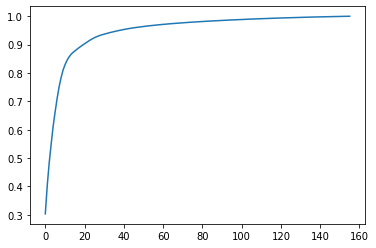

In [81]:
plt.plot(cumsum)

In [82]:
d = np.argmax(cumsum>=0.95)+1 

In [83]:
d

39

In [86]:
pca = PCA(n_components = 0.95)
X_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)

In [87]:
model = TimeSeriesForest(n_windows = 50, random_state = 42)
model.fit(X_reduced,y_train)
model.score(X_test_reduced,y_test)

0.4602739726027397

In [95]:
import numpy as np
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

#custom metric
def DTW(a, b):   
    an = a.size
    bn = b.size
    pointwise_distance = distance.cdist(a.reshape(-1,1),b.reshape(-1,1))
    cumdist = np.matrix(np.ones((an+1,bn+1)) * np.inf)
    cumdist[0,0] = 0

    for ai in range(an):
        for bi in range(bn):
            minimum_cost = np.min([cumdist[ai, bi+1],
                                   cumdist[ai+1, bi],
                                   cumdist[ai, bi]])
            cumdist[ai+1, bi+1] = pointwise_distance[ai,bi] + minimum_cost

    return cumdist[an, bn]

#train
clf = KNeighborsClassifier(metric=DTW)
clf.fit(X_train, y_train)



#evaluate
y_pred = clf.predict(X_test)

KeyboardInterrupt: 